# Scikit-Learn binary classification model training on local notebook. 
The code is plain vanilla Scikit-Learn training/creation of a binary classification model.Azure ML is only used to gather original data from an AML Dataset. This notebook can run on a local PC or on any Azure ML Compute Instance or Azure ML Compute Instance.

*This code is the baseline for the next labs/notebooks in the Workshop moving to AML remote compute, etc*

### Import libraries to use in notebook

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from azureml.core import Workspace, Dataset, Environment, Experiment
import joblib

print("Azure SDK version:", azureml.core.VERSION)

Azure SDK version: 1.19.0


### Create Workspace to load Tabular Datasets and to log local training into AML

In [5]:
# Connect to an existing Azure ML Workshop in order to use Azure ML Datasets and Runs Logging into AML
# if you run this locally download config.json and place it in root folder of the repo
# ws = Workspace.from_config('../../../config.json') 

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, sep='\n')

amlworkspacesahiep2141
MCW_Synapse
westeurope


In [16]:
import os
os.listdir('../../../../../../Data/datasets/')

['Automobile price data.csv',
 'german_credit_data.csv',
 'IBM-Employee-Attrition.csv']

### Load the German credit data

Note: as you are now accessing the workspace, the Notebook needs to be authenticated for access through device authentication. Hence, you will be prompted with a device login like so: 

    Performing interactive authentication. Please follow the instructions on the terminal.
    To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code XXXXX to authenticate.
    
Please follow these instructions in a new browser tab.

In Azure ML, *datastores* are references to storage locations, such as Azure Storage blob containers. Every workspace has a default datastore - usually the Azure storage blob container that was created with the workspace. If you need to work with data that is stored in different locations, you can add custom datastores to your workspace and set any of them to be the default.

Run the following code to determine the datastores in your workspace:

In [17]:
from azureml.core import Datastore

# Get the default datastore
default_ds = ws.get_default_datastore()

# Enumerate all datastores, indicating which is the default
for ds_name in ws.datastores:
    print(ds_name, "- Default =", ds_name == default_ds.name)

default_ds.upload(src_dir='../../../../../../Data/datasets/',
                 target_path='datasets',
                 overwrite=True)

azureml_globaldatasets - Default = False
sqlpool01 - Default = False
workspacefilestore - Default = False
workspaceblobstore - Default = True
Uploading an estimated of 3 files
Uploading ../../../../../../Data/datasets/Automobile price data.csv
Uploaded ../../../../../../Data/datasets/Automobile price data.csv, 1 files out of an estimated total of 3
Uploading ../../../../../../Data/datasets/german_credit_data.csv
Uploaded ../../../../../../Data/datasets/german_credit_data.csv, 2 files out of an estimated total of 3
Uploading ../../../../../../Data/datasets/IBM-Employee-Attrition.csv
Uploaded ../../../../../../Data/datasets/IBM-Employee-Attrition.csv, 3 files out of an estimated total of 3
Uploaded 3 files


$AZUREML_DATAREFERENCE_24b0e3a1b71f495cb0e32d7aaecbc6df

### Create and Register a Dataset
A dataset is an object that encapsulates a specific data source. Let's create a dataset from the german credit data you uploaded to the datastore, and view the first 3 records. In this case, the data is in a structured format in a CSV file, so we'll use a Tabular dataset.

In [19]:
from azureml.core import Dataset

# Create a tabular dataset from the path on the datastore (this may take a short while)
dataset = Dataset.Tabular.from_delimited_files(path = [(default_ds, './datasets/german_credit_data.csv')])

# preview the first 3 rows of the dataset
dataset.take(3).to_pandas_dataframe()

creditData = dataset.register(workspace = ws,
                                name = 'german-credit',
                                description = 'german credit data',
                                create_new_version = True)

In [20]:
# get the German credit dataset from the workspace
creditData = ws.datasets['german-credit'].to_pandas_dataframe()
creditData.head()

,Sno,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NA,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NA,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


## Clean up the initial dataset

In [21]:
# Dropping Sno column since it is merely an identifier
target = creditData["Risk"]
creditData = creditData.drop(['Sno'], axis=1)
creditXData = creditData.drop(['Risk'], axis=1)

## Split in Train and Test datasets (DataFrames)

In [22]:
# Split data into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(creditXData, 
                                                    target, 
                                                    test_size = 0.2,
                                                    random_state=0,
                                                    stratify=target)

## Transform data

In [23]:
# Collect the categorical and numerical column names in separate lists
categorical = []
for col, value in creditXData.iteritems():
    if value.dtype == 'object':
        categorical.append(col)
        
numerical = creditXData.columns.difference(categorical)

print(numerical)
print(categorical)

Index(['Age', 'Credit amount', 'Duration', 'Job'], dtype='object')
['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']


## Create data processing pipelines (Scikit-Learn pipelines)
NOTE: This code uses Scikit-Learn pipelines. Not related to AML Pipelines. Different concept. 

In [24]:
from sklearn.compose import ColumnTransformer

# We create the transformations pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transforms_pipeline = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])

## Add classifier algorithm (SVC: Support Vector Classifier) to the pipeline

In [25]:
# Append classifier to Scikit-Learn transformations pipeline.
# Now we have a full Scikit-Learn prediction pipeline.
model_pipeline = Pipeline(steps=[('preprocessor', transforms_pipeline),
                      ('classifier', SVC(kernel='linear', C = 1.0, probability=True))]) 

## Create AML Experiment, run and log just for logging info while training locally in Notebook

In [26]:
from azureml.core import Experiment

# Get an experiment object from AML
experiment = Experiment(workspace=ws, name="local-train-german-credit")

# Create a run object in the experiment
run =  experiment.start_logging()
# Log the algorithm parameter C to the run
run.log('C', 1.0)

## Train the SVM (Support Vector Machine) Classifier Model

In [27]:
model = model_pipeline.fit(x_train, y_train)

## Make Predictions and calculate Accuracy metric

In [28]:
from sklearn.metrics import accuracy_score

# Make Multiple Predictions
y_predictions = model.predict(x_test)

accuracy = accuracy_score(y_test, y_predictions)
print('Accuracy: ', accuracy)

Accuracy:  0.725


## Confusion Matrix

In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_predictions)
print(cm)

[[ 13  47]
 [  8 132]]


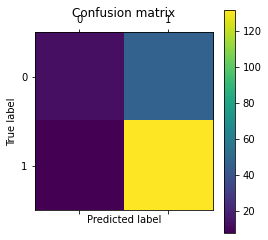

In [30]:
# Show confusion matrix in a separate window
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


## Log metric and model into the AML run definition
### Note that training is local, we just use the run definition to log information about the run/training 

In [31]:
# Log Image
run.log_image('Plot', plot=plt)

# Output the Accuracy to the notebook and to the run
run.log('accuracy', accuracy)

# Save the model to the outputs directory for capture
model_file_name = 'outputs/model.pkl'
joblib.dump(value = model, filename = model_file_name)

# Complete the run
run.complete()

<Figure size 432x288 with 0 Axes>

### Check the experiment run and its logged info in Azure ML Workspace
Now, you should go to your AML Workspace and check the information logged for this run, such as the accuracy, hyper-parameters and any other info you logged for the experiment run.

In [32]:
# One Prediction
instance_num = 1

# Get the prediction for the first member of the test set and explain why model made that prediction
prediction_value = model.predict(x_test)[instance_num]
print("One Prediction: ")
print(prediction_value)

One Prediction: 
good


In [33]:
predictions = pd.concat([x_test, y_test], axis=1)
predictions['prediction'] = y_predictions
predictions.head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,prediction
40,30,male,3,own,quite rich,NA,2333,30,radio/TV,good,good
383,26,male,2,own,little,rich,1330,12,car,good,good
986,33,male,2,own,little,rich,6289,42,business,good,good
79,22,male,2,own,little,moderate,3832,30,furniture/equipment,good,good
775,25,female,2,rent,NA,little,1371,24,car,bad,good
519,36,male,2,free,NA,NA,700,6,radio/TV,good,good
391,19,female,1,rent,rich,moderate,983,12,furniture/equipment,good,good
491,42,female,3,free,little,moderate,8318,27,business,bad,bad
847,28,male,2,own,little,NA,1249,24,car,good,good
71,46,male,1,rent,NA,NA,730,7,radio/TV,good,good


## Register the model 

In [34]:
from azureml.core.model import Model
model = Model.register(workspace = ws,    
                       model_path = "./outputs/model.pkl", # this points to a local file
                       model_name = "creditmodel_local", # this is the name the model is registered as
                       tags = {'area': "German credit risk", 'type': "Financial Services"},
                       description = "Binary classification model to understand credit risk based on the German credit risk data",
                      )

Registering model creditmodel_local
